In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from Models import LSTM
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

Load and Prepare data to input to LSTM model

In [3]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


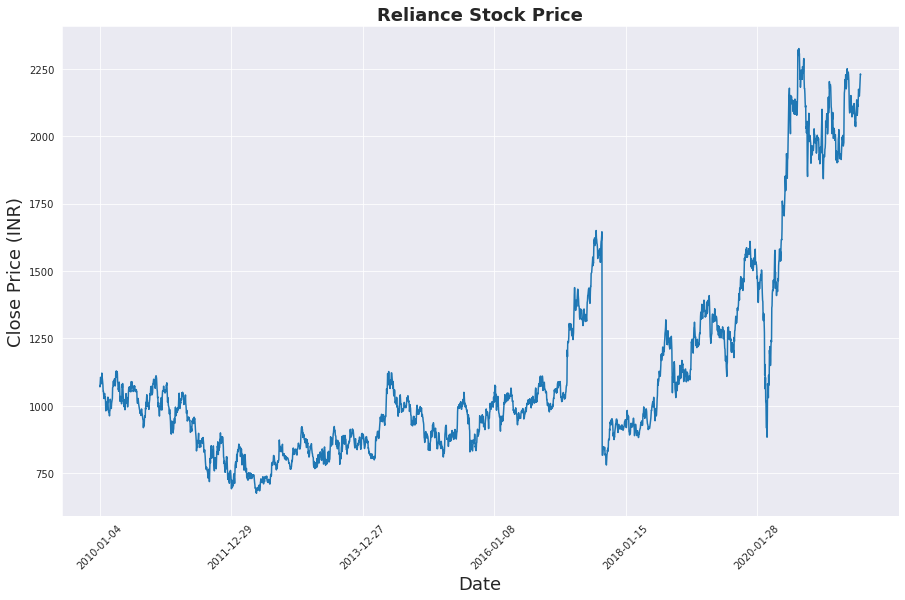

In [4]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Reliance Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [5]:
price = data[['Close']]

In [6]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [7]:
#Apply z-norm to data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

In [10]:
# Standardize the training and test set

def standardize_data(data):
    data_std = scaler.fit_transform(data.reshape(-1,1))
        
    return data_std

In [11]:
data_std = standardize_data(price['Close'].values)

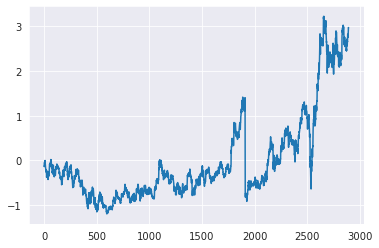

In [12]:
plt.plot(data_std)

In [13]:
train_set, test_set = splitData(data_std)

In [14]:
window_size = 2
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [15]:
x_train, y_train = prepareDataForTraining(train_set)
x_test, y_test = prepareDataForTraining(test_set)

In [16]:
x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [17]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2314, 2, 1)
y_train.shape =  (2314, 1)
x_test.shape =  (577, 2, 1)
y_test.shape =  (577, 1)


In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [19]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [20]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, '')]

<Figure size 432x288 with 0 Axes>

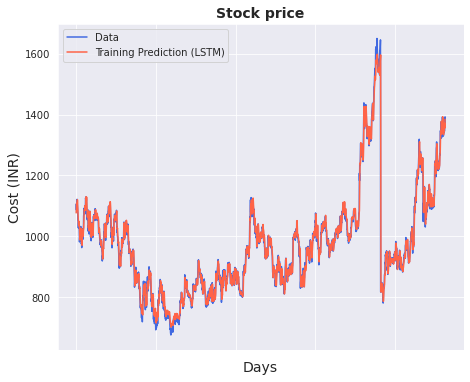

In [21]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (INR)", size = 14)
ax.set_xticklabels('', size=10)


In [22]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
accuracy_reg = r2_score(y_test, y_pred)
print('Test Score: %.2f RMSE' % (test_error))
print(f'R-squared value is {r2_score(y_test, y_pred)}')

Test Score: 222.31 RMSE
R-squared value is 0.637456023589808


In [23]:
def get_statistical_dist_measures_for_class_result(accuracy_reg, X_train, X_test):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = 1
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train, X_test)
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train, X_test)
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train, X_test)
        Kuiper_distances[i] = Kuiper_Dist(X_train, X_test)
        Wasserstein_distances[i] = Wasserstein_Dist(X_train, X_test)
        DTS_distances[i] = DTS_Dist(X_train, X_test)
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy_reg,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [24]:
#  Gets all ECDF statistical distance measures for current_label
dict_result_row = get_statistical_dist_measures_for_class_result(accuracy_reg,
                                                train_set, test_set)

In [25]:
result = pd.DataFrame([dict_result_row])
result.insert(1, 'RMSE', test_error)

In [26]:
result

,Accuracy,RMSE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.637456,222.313256,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_dist, test_dist = splitData(price['Close'])

In [28]:
#  Gets all ECDF statistical distance measures for current_label
dict_result_row = get_statistical_dist_measures_for_class_result(accuracy_reg,
                                                train_dist, test_dist)

In [29]:
result = pd.DataFrame([dict_result_row])
result.insert(1, 'RMSE', test_error)

In [30]:
result

,Accuracy,RMSE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.637456,222.313256,55.632354,1235.597582,39.789738,0.858377,0.858377,744.994171
